In [1]:
# This notebook provides a minimal example of definining a model and performing cross-validation.

In [2]:
from jax import random, numpy as jnp
import jax.scipy.stats as st
import ploo
import arviz as az


class GaussianModel(ploo.Model):
    name = "Gaussian mean model"

    def __init__(self, y):
        self.y = y
        self.folds = jnp.arange(0, len(y))

    def log_likelihood(self, model_params, cv_fold):
        ll = st.norm.logpdf(self.y, loc=model_params["mu"], scale=1.0)
        return jnp.where(self.folds != cv_fold, ll, 0).sum()

    def log_prior(self, model_params):
        return st.norm.logpdf(model_params["mu"], loc=0.0, scale=1.0)

    def log_cond_pred(self, model_params, cv_fold):
        y_tilde = self.y[cv_fold]
        return st.norm.logpdf(y_tilde, loc=model_params["mu"], scale=1.0)

    def initial_value(self):
        return {"mu": 0.0}

    def cv_folds(self):
        return len(self.y)

    @classmethod
    def generate(cls, N, mu, seed):
        rng_key = random.PRNGKey(seed=seed)
        return mu + random.normal(rng_key, shape=(N,))

In [3]:
# generate some data
y = GaussianModel.generate(N=50, mu=2.5, seed=42)
# fit full-data model
model = GaussianModel(y)
posterior = model.inference()

Thor's Cross-Validatory Hammer

Starting Stan warmup using NUTS...
      500 warmup draws took 3.9 sec (128.9 iter/sec).
Obtaining 16,000 full-data posterior draws (8 chains, 2,000 draws per chain)...
      16,000 HMC draws took 1.4 sec (11,353 iter/sec).


In [4]:
posterior.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.451,0.141,2.198,2.723,0.001,0.001,11272.0,12452.0,1.0


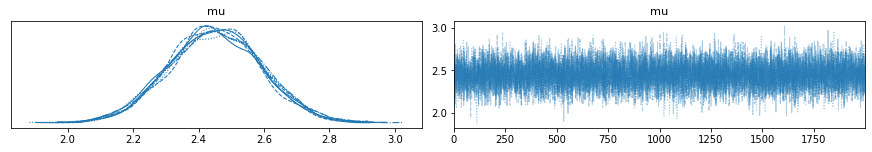

In [5]:
posterior.plot_trace();

In [6]:
cv = posterior.cross_validate()

Cross-validation with 50 folds using 400 chains...
      800,000 HMC draws took 3.0 sec (270,803 iter/sec).


In [7]:
cv

Cross-validation summary

    elpd = -1.4185 (se 0.0201)

Calculated from 50 folds (8 chains per fold, 400 total)

Average acceptance rate 82.3% (min 80.2%, max 84.5%)

Divergent chain count: 0

In [8]:
post0 = cv.arviz(cv_fold=0)

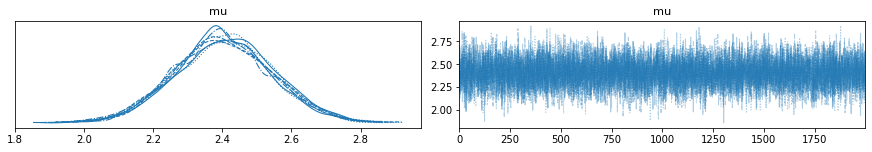

In [9]:
az.plot_trace(post0);

In [10]:
az.summary(post0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.404,0.142,2.141,2.674,0.001,0.001,10735.0,12367.0,1.0


In [11]:
# uncomment to see individual cv density plots
# cv.densities('mu')

In [12]:
# uncomment to see individual cv trace plots
# cv.trace_plots('mu')